In [14]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available!")
    # Configure TensorFlow to use the GPU
    tf.config.experimental.set_visible_devices(gpu_available[0], 'GPU')
else:
    print("No GPU available. Using CPU.")

GPU is available!


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, cross_val_score
import os
from itertools import cycle
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, linear_model, metrics, datasets, multiclass, svm
import seaborn as sns
import numpy.random as nr

In [16]:
Data = pd.read_csv('/content/consumer_complaints.csv')

/tmp/ipython-input-249489400.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv('/content/consumer_complaints.csv')


In [17]:
Data.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074.0
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080.0
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473.0
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326.0
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067.0


## Data understanding

In [18]:
Data.dtypes

,0
date_received,object
product,object
sub_product,object
issue,object
sub_issue,object
consumer_complaint_narrative,object
company_public_response,object
company,object
state,object
zipcode,object


In [19]:
pd.notnull(Data['consumer_complaint_narrative']).value_counts()

,count
consumer_complaint_narrative,
False,204142
True,1262


Take data which contain atleast 1 word which is to useful while model building, From the above output it shows `66806` are not null rows so we have to take only those rows.

In [20]:
print("Unique values and counts in 'consumer_complaint_narrative' before filtering:")
print(Data['consumer_complaint_narrative'].value_counts(dropna=False))

Data = Data[['product','consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
Data

Unique values and counts in 'consumer_complaint_narrative' before filtering:
consumer_complaint_narrative
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
...,...,...
205371,Consumer Loan,it was a rent to own managed by XXXX al.we wer...
205379,Mortgage,The mortgage loan against my primary residence...
205387,Debt collection,"Keep getting a call from this number, before i..."
205393,Mortgage,Greentree removes my tax money and does n't pa...


In [21]:
Data.shape

(1262, 2)

In [22]:
# check the distribution of complaint by category
Data.groupby('product').consumer_complaint_narrative.count()

,consumer_complaint_narrative
product,
Bank account or service,97
Consumer Loan,75
Credit card,162
Credit reporting,182
Debt collection,330
Money transfers,19
Mortgage,313
Other financial service,2
Payday loan,19


**Note:** Imbalance Dataset, `Other financial service`, `Money transfers`, `Payday loan`, `Prepaid card` are having less than `1000` rows denoting imbalance dataset

Let's Analyse it Graphically

## Splitting the data

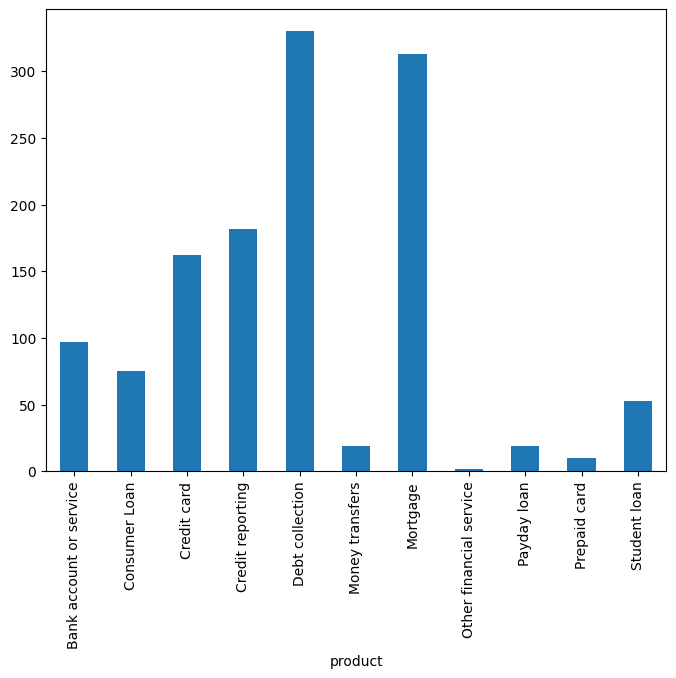

In [23]:
fig = plt.figure(figsize=(8,6))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar()
plt.show()

## Converting Text to Features

The procedure of converting raw text data into machine understandable format(numbers) is called feature engineering of text data. Machine learning and deep learning algo performance and accuracy is fundamentally dependent on the type of feature engineering techniques used.

## TF_IDF Vectorizer

TF_IDF is the most applied feature engineering technique for processing textual kind data by many machine learning expert and data scientist.

Term Frequency(TF): -> Term frequency is simply the ratio of the count of a word present in a sentence, to the length of the sentence.
                    -> TF is basically capturing the importance of the word irrespective of the length of the document.
                    -> ex: a word with the frequency of 3 with the length of sentence being 10 is not the same as when the word length of sentence being 100 words. It should get more importance in the first scenario; that is what TF does.
  
Inverse Document Frequency(IDF): -> IDF of each word is the log of the ratio of the total number of rows to the number of rows in a
                                    particular document in which that word is present.
                                 -> IDF will measure the rareness of a term. word like 'a' and 'the' show up in all the documents of                                           corpus, but the rare words is not in all the documents.
                                
TF-IDF is the simplest product of TF and IDF so that both of the drawbacks are addressed, which makes predictions and information retrieval relevant.

In [24]:
len(Data)

1262

In [25]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)    # default {max_df=1.0(float) so its proportion of word contain in all documents,
# simply if a words contain in all the document it is 1.0}, {min_df=1(int) so iteger directly denotes count of words in a document shows atleast 1 word contains in a documents then only it is consider}
tfidf_vect.fit(Data['consumer_complaint_narrative'])
Features = tfidf_vect.transform(Data['consumer_complaint_narrative'])

encoder = preprocessing.LabelEncoder()
Labels1 = encoder.fit_transform(Data['product'])

# Binarize the output
#Labels = np.array(preprocessing.label_binarize(Labels, classes=[0,1,2,3,4,5,6,7,8,9,10]))

In [26]:
print(Features[0], Labels1)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 41 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 1)	0.15241305933215
  (0, 86)	0.4961323976000318
  (0, 223)	0.04159830339904673
  (0, 357)	0.08083138536715248
  (0, 363)	0.15181218289562445
  (0, 369)	0.12635731396048377
  (0, 401)	0.12285717978530915
  (0, 426)	0.0813603304957571
  (0, 497)	0.07164518824846655
  (0, 716)	0.12806569701975018
  (0, 838)	0.08830827464312224
  (0, 841)	0.19283104228921683
  (0, 937)	0.11698006082390582
  (0, 969)	0.17531666714992056
  (0, 1009)	0.1066748675919679
  (0, 1163)	0.13252250618747183
  (0, 1414)	0.1531724722284795
  (0, 1939)	0.1481160347793561
  (0, 1980)	0.20206021613975814
  (0, 2151)	0.18226631714190528
  (0, 2161)	0.07437828000830618
  (0, 2260)	0.11037086150169259
  (0, 2281)	0.202754283085838
  (0, 2411)	0.23987156133811854
  (0, 2474)	0.22751508507489884
  (0, 2787)	0.052720640431297316
  (0, 3064)	0.04555617311001683
  (0, 3168)	0.2597148962713167
  (0, 3186)	0

Next, execute the code in the cell below to split the dataset into test and training set. Notice that usually, 25% of the 100% cases are being used as the test dataset.

In [27]:
train_x, valid_x,  train_y, valid_y = train_test_split(Data['consumer_complaint_narrative'],Data['product'])    # Default it will split 25 by 75% means 25% test case and 75% training cases

In [28]:
train_x

,consumer_complaint_narrative
202604,XXXX XXXX XXXX transferred the servicing of my...
197395,I have a XXXX Paypal accounts. Sometimes I tra...
203835,Wells Fargo lies and continues to assert that ...
202737,The lady from the finance company calls as man...
205387,"Keep getting a call from this number, before i..."
...,...
200667,The credit report listed an item : XXXX Seriou...
199925,Capital One has continuously charged me late f...
196649,The complaint i am filing is against XXXX XXXX...
197542,I had a charge that was charged my card as an ...


In [29]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)


tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern='\w{1,}', max_features=5000)    # default {max_df=1.0(float) so its proportion of word contain in all documents,
# simply if a words contain in all the document it is 1.0}, {min_df=1(int) so iteger directly denotes count of words in a document shows atleast 1 word contains in a documents then only it is consider}
tfidf_vect.fit(Data['consumer_complaint_narrative'])
print(tfidf_vect.stop_words)
print(tfidf_vect.vocabulary_)
xtrain_tfidf = tfidf_vect.transform(train_x)
#print(xtrain_tfidf)
xvalid_tfidf = tfidf_vect.transform(valid_x)

None
{'xxxx': np.int64(4967), 'has': np.int64(2161), 'claimed': np.int64(969), 'i': np.int64(2281), 'owe': np.int64(3168), 'them': np.int64(4441), '27': np.int64(86), '00': np.int64(1), 'for': np.int64(1939), 'years': np.int64(4982), 'despite': np.int64(1414), 'the': np.int64(4436), 'proof': np.int64(3471), 'of': np.int64(3064), 'payment': np.int64(3231), 'sent': np.int64(4017), 'canceled': np.int64(841), 'check': np.int64(937), 'and': np.int64(426), 'their': np.int64(4439), 'invoice': np.int64(2474), 'they': np.int64(4452), 'continue': np.int64(1163), 'to': np.int64(4508), 'insist': np.int64(2411), 'collection': np.int64(1009), 'agencies': np.int64(363), 'are': np.int64(497), 'after': np.int64(357), 'me': np.int64(2787), 'how': np.int64(2260), 'can': np.int64(838), 'stop': np.int64(4254), 'this': np.int64(4462), 'harassment': np.int64(2151), 'a': np.int64(223), 'bill': np.int64(716), 'already': np.int64(401), 'paid': np.int64(3186), 'four': np.int64(1980), 'ago': np.int64(369), 'due':

In [30]:
train_y_df = pd.DataFrame(train_y)
display(train_y_df)

,0
0,6
1,0
2,0
3,4
4,4
...,...
941,2
942,2
943,2
944,0


In [31]:
train_x_df = pd.DataFrame(xtrain_tfidf)
display(train_x_df)

,0
0,<Compressed Sparse Row sparse matrix of dtype ...
1,<Compressed Sparse Row sparse matrix of dtype ...
2,<Compressed Sparse Row sparse matrix of dtype ...
3,<Compressed Sparse Row sparse matrix of dtype ...
4,<Compressed Sparse Row sparse matrix of dtype ...
...,...
941,<Compressed Sparse Row sparse matrix of dtype ...
942,<Compressed Sparse Row sparse matrix of dtype ...
943,<Compressed Sparse Row sparse matrix of dtype ...
944,<Compressed Sparse Row sparse matrix of dtype ...


##  LogisticRegression Model building

Suppose we are building a linear classifier on word-level TF-IDF vectors. We are using default hyper parameters for the classifier.

In [32]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)

In [33]:
model

LogisticRegression()

LogisticRegression  Model Evaluation

In [34]:
def accuracy():
    accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf),valid_y)
    print("Accuracy: ",accuracy)
    print(metrics.classification_report(valid_y,model.predict(xvalid_tfidf), target_names=Data['product'].unique()))

accuracy()

Accuracy:  0.6772151898734177
                         precision    recall  f1-score   support

        Debt collection       0.75      0.35      0.48        17
          Consumer Loan       1.00      0.04      0.08        23
               Mortgage       0.79      0.64      0.71        42
            Credit card       0.65      0.78      0.70        40
       Credit reporting       0.69      0.85      0.77        96
           Student loan       0.00      0.00      0.00         6
Bank account or service       0.62      0.92      0.74        72
            Payday loan       0.00      0.00      0.00         1
        Money transfers       0.00      0.00      0.00         4
Other financial service       0.00      0.00      0.00         2
           Prepaid card       1.00      0.08      0.14        13

               accuracy                           0.68       316
              macro avg       0.50      0.33      0.33       316
           weighted avg       0.69      0.68      0.62    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Examine these results:
1. The overall accuracy is 0.846. However as just observed this is as somewhat misleading beacuse of some cases like `money transfer`, `payday loan`, and `other financial service` are little misclassified.
3. The class imbalance is confirmed. Of the 33, 190, 210 cases are very less than as compaire to 4370 or 3700.
4. The precision, recall and F1 all show that Debt collection, Mortgage, Credit card, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, but the Consumer Loan, Student loan, Payday loan, Money transfers, Other financial service cases are not. As if those categories are misclassified is will directly cost to bank, beacause after going complaint to unexpected team they will not able to resolve the issues and ticket is going to send to appropriate team so, increases time range and directly impacts to customer satisfaction leads to high risk on customer relationship mangement by bank. since bank fully depends on customers they should not tollerate it.    

Let's Analyse the correctly classified and misclassified data closely by heatmap structure and confusion matrix.

[[ 6  0  2  1  2  0  6  0  0  0  0]
 [ 0  1  0  3  9  0 10  0  0  0  0]
 [ 0  0 27  4  7  0  4  0  0  0  0]
 [ 0  0  1 31  3  0  5  0  0  0  0]
 [ 0  0  2  7 82  0  5  0  0  0  0]
 [ 1  0  0  0  3  0  2  0  0  0  0]
 [ 0  0  1  2  3  0 66  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  2  0  2  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  5  0  0  0  1]]


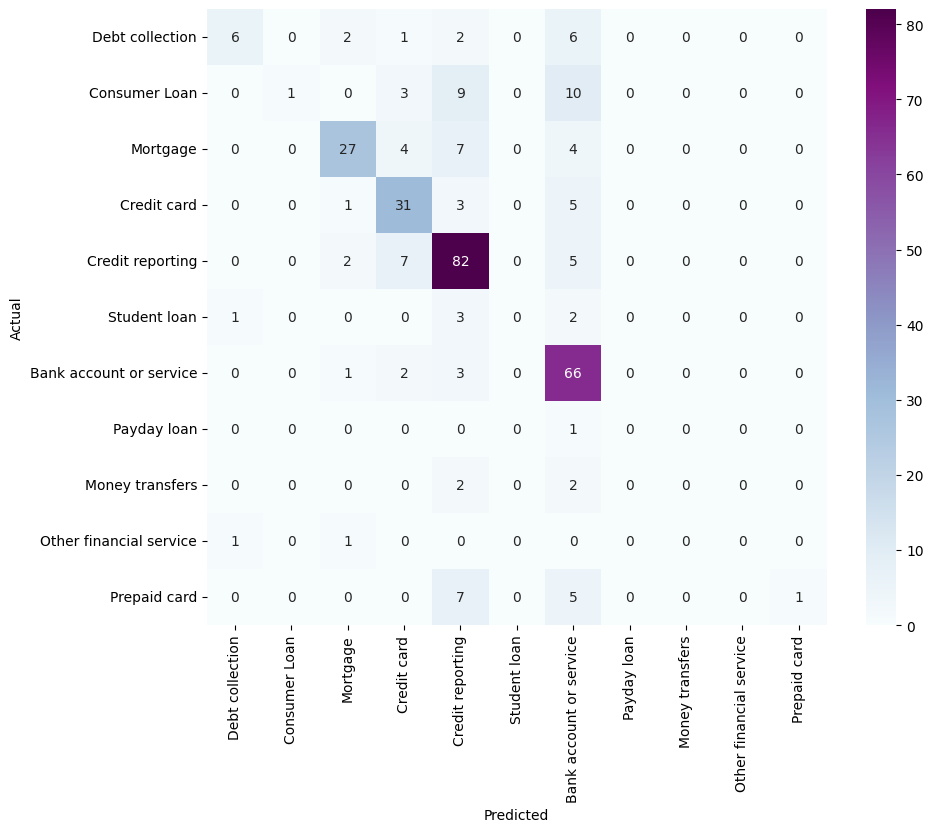

In [35]:
def heat_conf():
    # confusion matrix
    conf_mat = metrics.confusion_matrix(valid_y,model.predict(xvalid_tfidf))
    print(conf_mat)
    # visualizing confusion matrix
    #category_id_df = Data[['product','category_id']].drop_duplicates().sort_values('category_id')
    #category_id_df
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(conf_mat, annot=True,fmt='d',cmap='BuPu',xticklabels=Data['product'].unique(),yticklabels=Data['product'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

heat_conf()

Examine the result:      
The confusion matrix shows the following characteristics; a) Debt collection, Mortgage, Credit card, Consumer Loan, Credit reporting, Bank account or service, Prepaid card cases are classified reasonably well, b) but the Student loan, Payday loan, Money transfers, Other financial service cases are not however,

In [36]:
category_id_df = pd.DataFrame()
category_id_df['category'] = Data['product'].unique()
category_id_df['category_id'] = category_id_df.index.values

#print(category_id_df.index.values)
category_to_id = dict(category_id_df[['category_id','category']].values)
category_to_id

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

In [37]:
probabilities = model.predict_proba(xvalid_tfidf)
print(probabilities[:15,:])

[[5.71257085e-02 3.68336385e-02 7.92293570e-02 4.60161524e-01
  1.77803961e-01 1.24412038e-02 1.15991201e-01 1.07156345e-03
  1.38541342e-02 7.75938327e-03 3.77283245e-02]
 [2.69661186e-02 2.45590089e-02 4.01667468e-02 4.83461213e-02
  7.70327115e-01 7.34224588e-03 4.40869671e-02 6.09569032e-04
  1.03045654e-02 4.96568110e-03 2.23258605e-02]
 [7.18692015e-02 5.37232361e-02 3.85838523e-01 9.37375708e-02
  1.60487615e-01 1.94502890e-02 1.42853163e-01 1.29017512e-03
  1.95205792e-02 1.18347974e-02 3.93948498e-02]
 [3.34319150e-02 2.76902459e-02 3.53276452e-02 4.05826134e-02
  6.75118012e-02 7.06016807e-03 7.49030147e-01 6.36065028e-04
  1.01355535e-02 4.64353789e-03 2.39503079e-02]
 [3.45980787e-02 4.82411875e-02 1.01665443e-01 5.27390905e-01
  1.88640171e-01 1.20376843e-02 4.73607051e-02 9.25710371e-04
  1.43299439e-02 6.94676317e-03 1.78634081e-02]
 [3.14311607e-01 6.89772418e-02 1.05932847e-01 6.60684940e-02
  2.26937389e-01 2.38360592e-02 1.22050816e-01 1.36174243e-03
  2.37295325e-02

The above shows probablitic approach towards the classification problem, where the highest prob belongs to the perticular class. for ex: see the 1st row it belongs to class 3. its value ranges [0-1]

Now the below code shows that The desion_function() tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). Based on that information, the estimator then label the examples with the corresponding label.

In [38]:
y_score = model.decision_function(xvalid_tfidf)
print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
print(predictions[:15])

[[ 0.5009073   0.06206457  0.82799995  2.58723062  1.63633465 -1.0233331
   1.20916739 -3.4752282  -0.91576326 -1.49544409  0.08606418]
 [ 0.29098214  0.19747968  0.68944039  0.87478693  3.64321618 -1.00995429
   0.78256514 -3.49860215 -0.67101203 -1.4010486   0.1021466 ]
 [ 0.53544474  0.24444253  2.21601587  0.801096    1.33881369 -0.77154115
   1.2224142  -3.48462512 -0.76793383 -1.26835895 -0.06576799]
 [ 0.46776554  0.27933477  0.52292036  0.66159429  1.17055697 -1.08727659
   3.57703379 -3.49419992 -0.72569606 -1.50626889  0.13423573]
 [ 0.15275226  0.48516728  1.23064157  2.87689614  1.84879545 -0.9030038
   0.46674699 -3.46823976 -0.72869456 -1.45277007 -0.50829151]
 [ 1.94678111  0.43017286  0.85920161  0.38708823  1.6210704  -0.63240424
   1.00083371 -3.49483868 -0.6368834  -1.16998403 -0.31103755]
 [ 0.3615028   0.49707143  0.53030106  0.67385612  2.54687771 -1.03654555
   1.777567   -3.49740165 -0.82605804 -1.48702119  0.45985031]
 [ 0.21983477  0.48914851  1.16172811  0.86

In [39]:
# Binarize the output
y = preprocessing.label_binarize(valid_y, classes=[0,1,2,3,4,5,6,7,8,9,10])
n_classes = y.shape[1]
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

Finally, the code in the cell below computes and displays the ROC curve and AUC. The `roc_curve` and `auc` functions from the scikit-learn `metrics` package are used to compute these values.

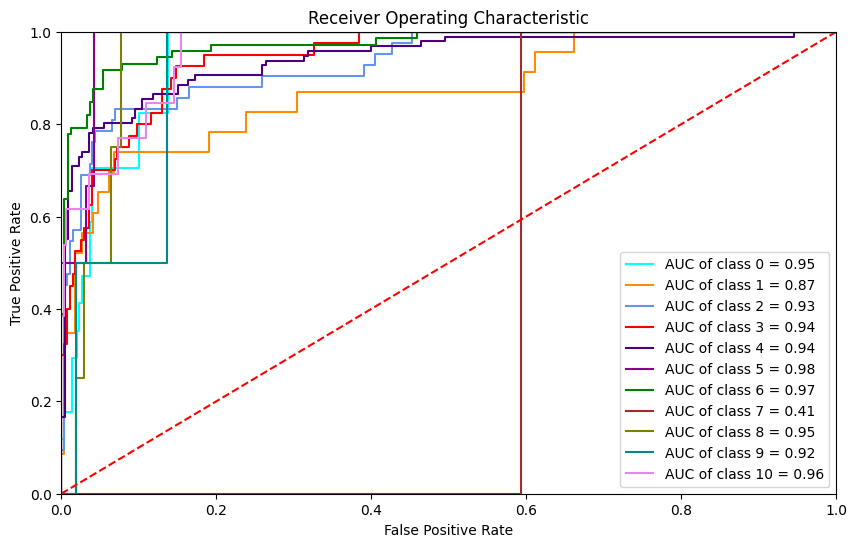

In [40]:
def plot_auc(labels, colours=['orange']):

    # Compute ROC curve and ROC area for each class
    n_classes = len(category_to_id)
    # print(n_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:,i], y_score[:, i])
    #     print(fpr[i], tpr[i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,6))
    for i, color in zip(range(n_classes), colours):
        plt.plot(fpr[i], tpr[i], color = color, label = 'AUC of class {0} = {1:0.2f}'.format(i,roc_auc[i]))

    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

colours = ['aqua', 'darkorange', 'cornflowerblue','r','indigo','darkmagenta','green','brown','olive','darkcyan','violet']
plot_auc(y, colours)    # in place of probabilities we can put y_score of decision function as well. will get a same result.

The above graph if for all the classified ROC curves with different colors. legends shows that all the auc are much higher and well correctly classified consumer complaints, mostly values are above 0.95 excepting some for 0.89. This curves shows that we have build a perfectly nice model as expected which is mostly classified correct complaints.

## Compute a weighted model

Recall that a falsely classifying a some categorical product customer as different category, cost high to bank and followup time to customers increses. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model.
2. Nothing has been done to weight the results toward correctly classifying perticular product category data.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below adds a `class_weight` argument to the call to the `LogisticRegression` function. In this case weights are chosen as 5 for class 5 and 10 for class 7  but you can also give another combination. Execute this code

**Note:** default class_weights are 1

In [41]:
result_metric = metrics.precision_recall_fscore_support(train_y,model.predict(xtrain_tfidf))
num_cases = result_metric[3][:]
print(num_cases.sort())
print(sum(num_cases))
label_dic = {i:j for i,j in zip(num_cases,range(len(num_cases)))}
print(label_dic)
perc = []
for i in range(len(num_cases)):
    perc.append(num_cases[i]/sum(num_cases))
perc_rev = sorted(perc,reverse=True)
num_cases.sort()
#print(perc_rev)
class_weights = {label_dic[i]:j for i,j in zip(num_cases,perc_rev)}

print(class_weights)

None
946
{np.int64(1): 0, np.int64(8): 1, np.int64(13): 2, np.int64(15): 3, np.int64(40): 4, np.int64(52): 5, np.int64(80): 6, np.int64(120): 7, np.int64(142): 8, np.int64(234): 9, np.int64(241): 10}
{0: np.float64(0.2547568710359408), 1: np.float64(0.24735729386892177), 2: np.float64(0.15010570824524314), 3: np.float64(0.12684989429175475), 4: np.float64(0.08456659619450317), 5: np.float64(0.05496828752642706), 6: np.float64(0.042283298097251586), 7: np.float64(0.015856236786469344), 8: np.float64(0.013742071881606765), 9: np.float64(0.008456659619450317), 10: np.float64(0.0010570824524312897)}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
from collections import Counter
Counter(train_y)

Counter({np.int64(6): 241,
         np.int64(0): 80,
         np.int64(4): 234,
         np.int64(2): 120,
         np.int64(10): 40,
         np.int64(1): 52,
         np.int64(5): 13,
         np.int64(3): 142,
         np.int64(9): 8,
         np.int64(8): 15,
         np.int64(7): 1})

In [43]:
model = linear_model.LogisticRegression(class_weight = {8:3.0, 9:3, 5:3.0, 7:20}).fit(xtrain_tfidf, train_y)
model

LogisticRegression(class_weight={5: 3.0, 7: 20, 8: 3.0, 9: 3})

Accuracy:  0.680379746835443
                         precision    recall  f1-score   support

        Debt collection       0.67      0.35      0.46        17
          Consumer Loan       1.00      0.04      0.08        23
               Mortgage       0.79      0.64      0.71        42
            Credit card       0.65      0.78      0.70        40
       Credit reporting       0.69      0.85      0.77        96
           Student loan       1.00      0.17      0.29         6
Bank account or service       0.63      0.92      0.75        72
            Payday loan       0.00      0.00      0.00         1
        Money transfers       0.00      0.00      0.00         4
Other financial service       0.00      0.00      0.00         2
           Prepaid card       1.00      0.08      0.14        13

               accuracy                           0.68       316
              macro avg       0.59      0.35      0.35       316
           weighted avg       0.71      0.68      0.63     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


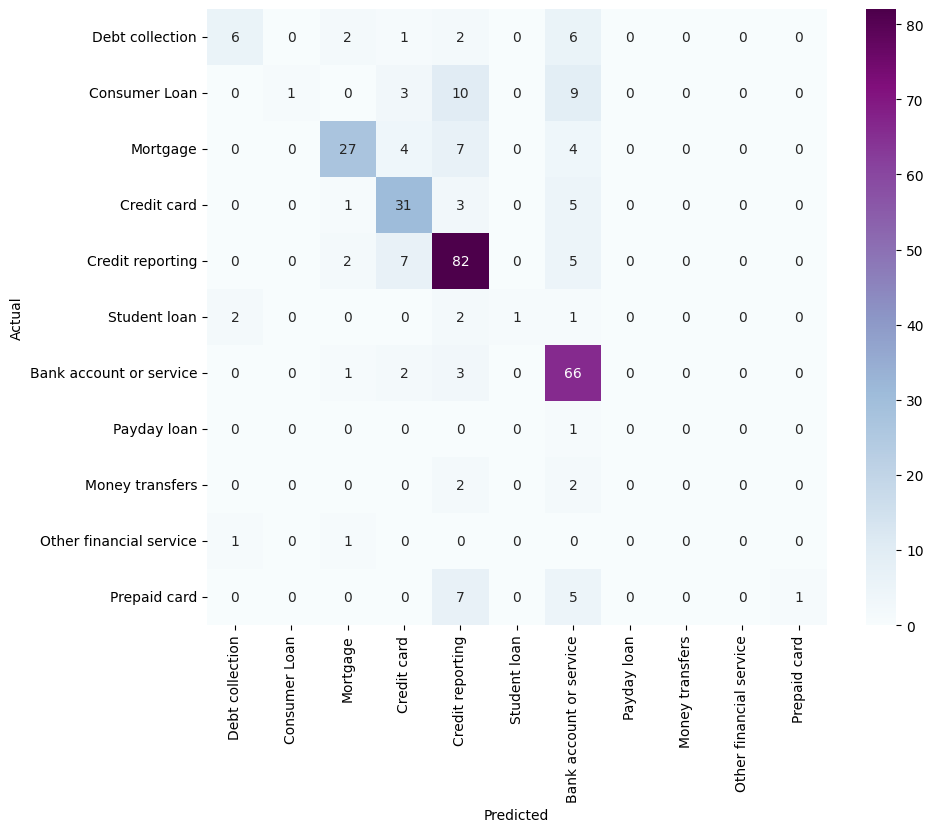

In [44]:
accuracy()
heat_conf()

In [45]:
y_score = model.decision_function(xvalid_tfidf)
print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
print(predictions[:15])

[[ 1.45637214e-01 -2.97394399e-01  5.00846870e-01  2.28245023e+00
   1.32326300e+00 -7.23694913e-01  8.78116831e-01 -2.05890388e+00
  -6.15118389e-01 -1.16299859e+00 -2.72203976e-01]
 [-8.12647567e-02 -1.75385605e-01  3.31579725e-01  5.16400311e-01
   3.33299401e+00 -7.42424234e-01  4.27844184e-01 -2.17045330e+00
  -2.05410344e-01 -9.64856415e-01 -2.69023580e-01]
 [ 1.17681972e-01 -1.57799613e-01  1.82357644e+00  4.05763105e-01
   9.44889443e-01 -2.72108517e-01  8.25677505e-01 -2.10584232e+00
  -4.18460656e-01 -7.03430730e-01 -4.59946629e-01]
 [ 1.19985679e-01 -7.45514641e-02  1.84526976e-01  3.27865265e-01
   8.26612235e-01 -8.81555820e-01  3.29077439e+00 -2.15656964e+00
  -2.33087551e-01 -1.18532078e+00 -2.18679285e-01]
 [-2.51707761e-01  9.98242553e-02  8.57988507e-01  2.54536510e+00
   1.47293983e+00 -5.15572120e-01  6.74233862e-02 -2.01784500e+00
  -2.71839224e-01 -1.09168283e+00 -8.94894141e-01]
 [ 1.48628357e+00 -3.79413219e-03  3.80767077e-01 -7.80734191e-02
   1.11578476e+00  

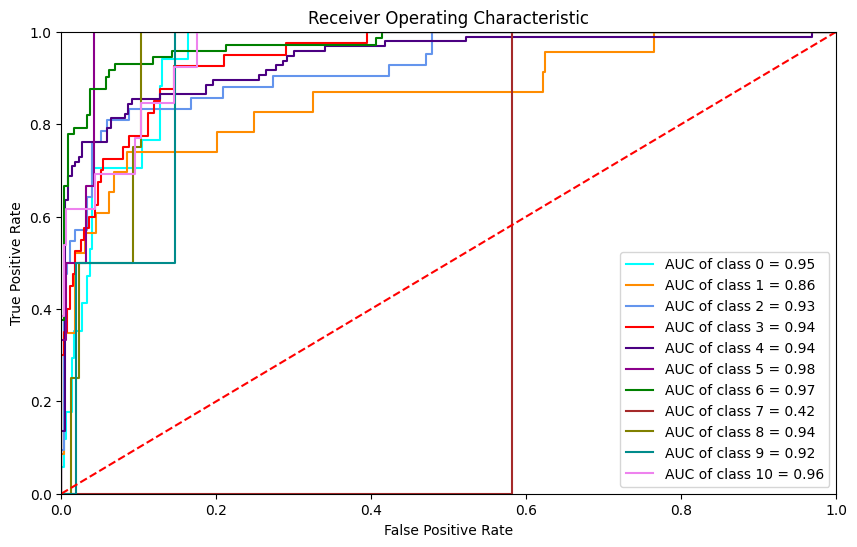

In [46]:
plot_auc(y, colours)    # in place of probabilities we can put y_score of decision function as well. will get a same result.

The accuracy is slightly changed with respect to the unweighted model. The change could be more had we give more weights to `Payday Loan`, `Money Transfers`, `Other financial services` of the class than what we did here. The precision, recall and F1 are slightly better for the these cases. Reweighting the labels has moved the results in the desired direction, at least a bit.

The trade-off between true positive and false positive is similar to the unweighted model.

In [47]:
texts = ['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)
# print(predictions)
print(texts)
print("   -Predicted as: {}".format(category_to_id[predictions[0]]))

['This account popped up on my credit and it is not mines. I have filled out all the correct docs to show that i am victim of identity thief and will attach the ftc report with this complaint. Please block and remove this from my credit please XXXX XXXX XXXX Account Number: XXXX XXXX / 2019']
   -Predicted as: Credit card


## Cross validate model

To compute a better estimate of model performance, you can perform simple cross validation. The code in the cell performs the following processing:
1. Create a list of the metrics to be computed for each fold.
2. Defines a logistic regression model object.
3. A 10 fold cross validation is performed using the `cross_validate` function from the scikit-learn `model_selection` package.

Execute this code.

In [48]:
#Labels = Labels.reshape(Labels.shape[0])
# Binarize the output
#Labels = preprocessing.label_binarize(Labels, classes=[0,1,2,3,4,5,6,7,8,9,10])
#Labels = np.array(Labels)
print(Labels1)


scoring = ['precision_macro','recall_macro']
logistic_mod = linear_model.LogisticRegression(C = 1.0, class_weight = {8:3.0, 9:3, 5:3.0, 7:20})
scores = ms.cross_validate(logistic_mod, Features, Labels1, scoring=scoring,
                        cv=10, return_train_score=False)

[4 1 6 ... 4 6 6]


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

The code in the cell below displays the performance metrics along with the mean and standard deviation, computed for each fold to the cross validation. The 'macro' versions of precision and recall are used. These macro versions average over the all the multinomial cases.

In [49]:
def print_format(f,x,y):
    print('Fold %2d    %4.3f        %4.3f' % (f, x, y))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall')
    [print_format(f,x,y) for f,x,y in zip(fold, scores['test_precision_macro'],
                                          scores['test_recall_macro'])]

    print('-' * 30)
    print('Mean       %4.3f        %4.3f '%
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro'])))
    print('Std        %4.3f        %4.3f '%
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro'])))

print_cv(scores)

         Precision     Recall
Fold  1    0.544        0.367
Fold  2    0.404        0.358
Fold  3    0.580        0.397
Fold  4    0.473        0.432
Fold  5    0.474        0.387
Fold  6    0.557        0.389
Fold  7    0.651        0.463
Fold  8    0.512        0.416
Fold  9    0.557        0.412
Fold 10    0.551        0.439
------------------------------
Mean       0.530        0.406 
Std        0.065        0.031 


Notice that there is considerable variability in each of the performance metrics from fold to fold. Even so, the standard deviations are at least an order of magnitude than the means. It is clear that **any one fold does not provide a representative value of the performance metrics**. The later is a key point as to why cross validation is important when evaluating a machine learning model.  

Compare the performance metric values to the values obtained for the baseline model you created above. In general the metrics obtained by cross validation are lower. However, the metrics obtained for the baseline model are within 1 standard deviation of the average metrics from cross validation.

## Support Vector machine model

Nested cross validation is used to estimate the optimal hyperparameters and perform model selection for the nonlinear SVM model. 5 fold cross validation is used since training SVMs are computationally intensive to train. Additional folds would give better estimates but at the cost of greater computation time. Execute the code in the cell below to define inside and outside fold objects.

In [50]:
nr.seed(248)
inside = ms.KFold(n_splits=5, shuffle = True)
nr.seed(135)
outside = ms.KFold(n_splits=5, shuffle = True)

In [51]:
Labels = preprocessing.label_binarize(Labels1, classes=[0,1,2,3,4,5,6,7,8,9,10])
print(Labels)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [52]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"estimator__C": [1, 10, 100, 1000]}
## Define the SVM model
svc_clf = svm.LinearSVC()

svc_multi_clf = multiclass.OneVsRestClassifier(svc_clf)
## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = svc_multi_clf, param_grid = param_grid,
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)
clf.fit(Features, Labels)
print(clf.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: Undefi

{'estimator__C': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan]
  warnings.warn(


In [53]:
nr.seed(498)
cv_estimate = cross_val_score(clf, Features, Labels,
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_

Mean performance metric =  nan
SDT of the metric       =  nan
Outcomes by cv fold
Fold  1     nan
Fold  2     nan
Fold  3     nan
Fold  4     nan
Fold  5     nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [54]:
model = svm.LinearSVC(class_weight={8:3.0, 9:3, 5:3.0, 7:20}).fit(xtrain_tfidf, train_y)

Accuracy:  0.7689873417721519
                         precision    recall  f1-score   support

        Debt collection       0.53      0.53      0.53        17
          Consumer Loan       0.69      0.48      0.56        23
               Mortgage       0.81      0.83      0.82        42
            Credit card       0.67      0.82      0.74        40
       Credit reporting       0.82      0.82      0.82        96
           Student loan       1.00      0.33      0.50         6
Bank account or service       0.81      0.92      0.86        72
            Payday loan       0.00      0.00      0.00         1
        Money transfers       0.00      0.00      0.00         4
Other financial service       0.00      0.00      0.00         2
           Prepaid card       0.80      0.62      0.70        13

               accuracy                           0.77       316
              macro avg       0.56      0.49      0.50       316
           weighted avg       0.76      0.77      0.76    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


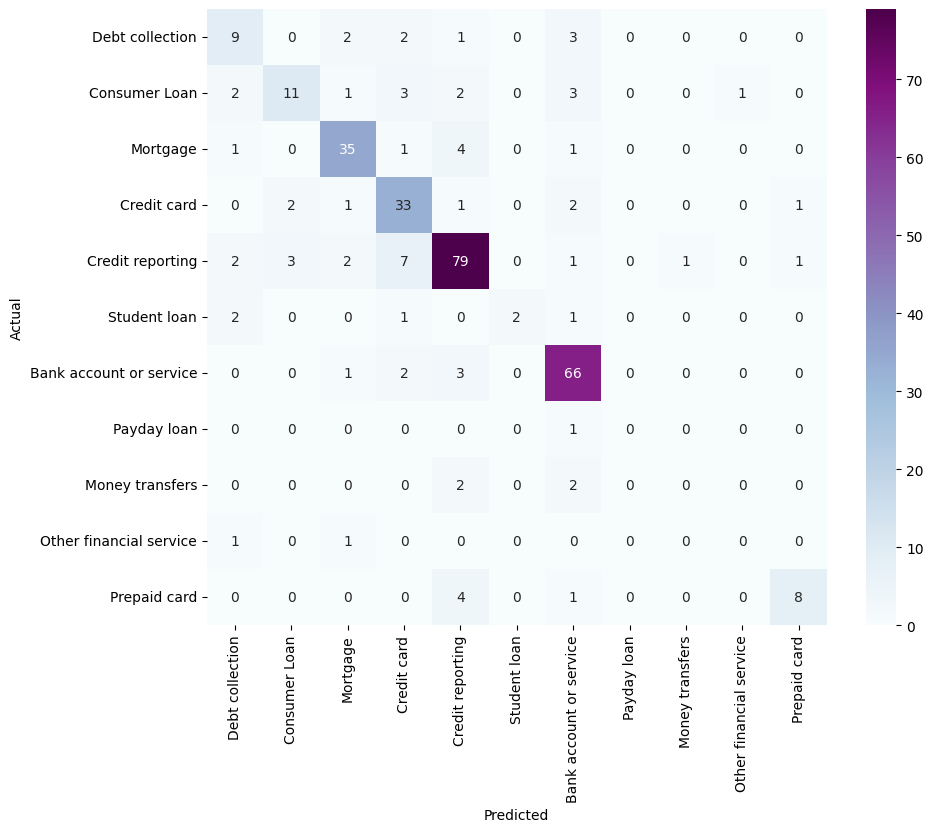

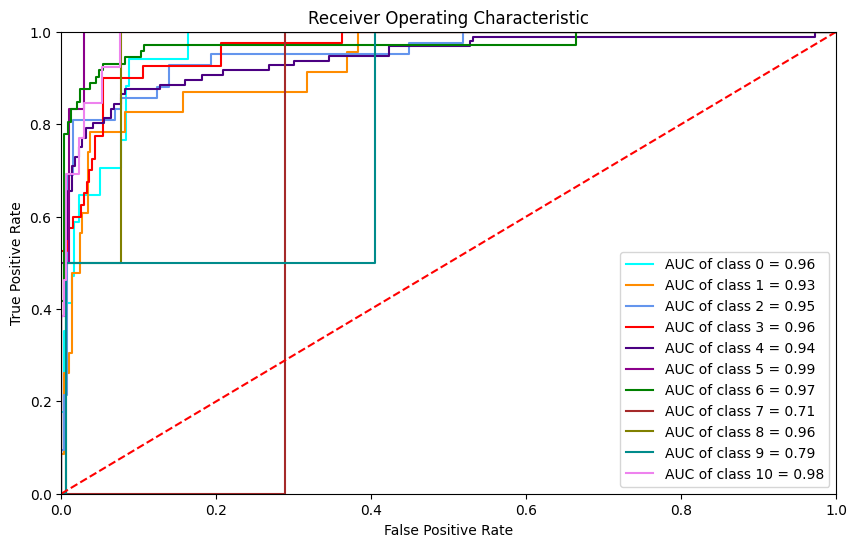

In [55]:
accuracy()
heat_conf()
y_score = model.decision_function(xvalid_tfidf)
# print(y_score[:15,:])
predictions = model.predict(xvalid_tfidf)
# print(predictions[:15])

plot_auc(y,colours)